# Esonero 2 - 17 Maggio 2021

Completare i seguenti esercizi tramite uno o più blocchi di codice descrivendo le operazioni effettuate


In [167]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import misc, ndimage


import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models

from torchsummary import summary

# Esercizio 1

Data la seguente immagine, costruire la feature pyramid di gaussiane e descrivere il procedimento

![](figure1.jpg)

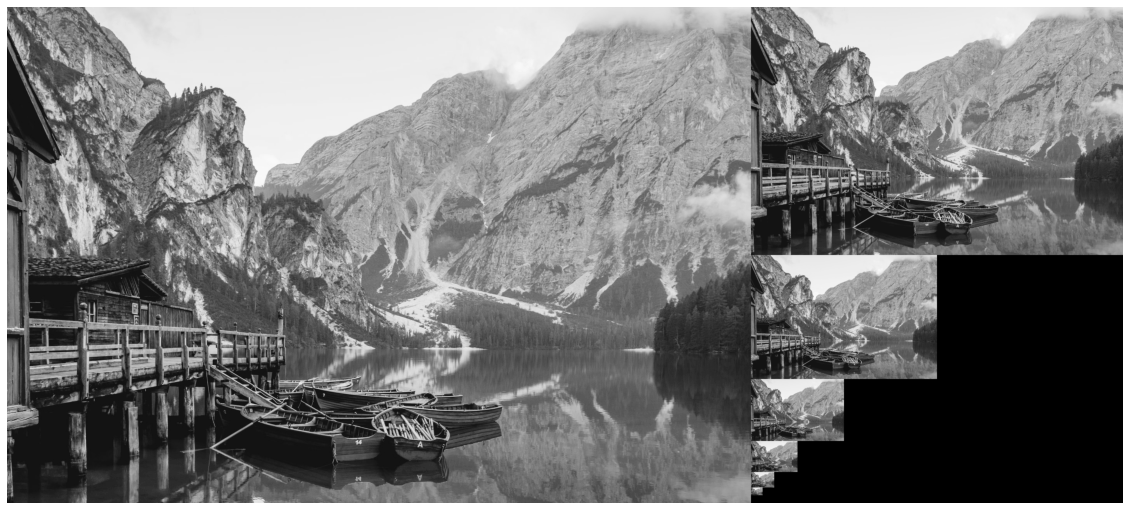

In [168]:
#Genero la piramide gaussiana non suddividendo per ottave

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def gaussianPyramid(image):
    rows,cols = image.shape
    output = np.zeros((rows,cols+cols//2))
    output[:rows,:cols] = image

    num_octave = 6
    sigma = 0.5

    cur_scale = image

    horiz = True
    rows = 0

    for i in range(num_octave):
        cur_scale = ndimage.gaussian_filter(cur_scale,sigma)
        cur_scale = cur_scale[::2,::2]
        rows_scaled, cols_scaled = cur_scale.shape
        output[rows:rows+rows_scaled,cols:cols+cols_scaled] = cur_scale
        rows += rows_scaled
        
    return output

image = plt.imread("./figure1.jpg")
image = rgb2gray(image)
output = gaussianPyramid(image)
plt.figure(figsize=(20, 20))

plt.imshow(output,cmap="gray")
plt.axis('off')
plt.show() 

In [169]:
# Stesso procedimento ma considerando anche le ottave

def plot_pyramid(p,sz,hspace=10,vspace=10):
    rows, cols = sz[0],sz[1]

    nrows = sum([x[0].shape[0] for x in p]) +  vspace*(num_octave-1)
    ncols = cols*(s+3)+hspace*(s+2)
    output_image = np.ones((nrows,ncols))

    r = 0
    for i in range(len(p)):
        c = 0
        for j in range(len(p[i])):
            w,h = p[i][j].shape
            output_image[r:r+w,c:c+h] = p[i][j]
            c += cols + hspace
        r += w + vspace
    
    return output_image

def generate_octave(init_level, s, sigma): 
    octave = [init_level] 
    k = 2**(1/s) 
    for _ in range(s+2): 
        next_level = ndimage.gaussian_filter(octave[-1],k * sigma)
        octave.append(next_level) 
    return octave

def generate_gaussian_pyramid(im, num_octave, s, sigma): 
    pyr = [] 
    for _ in range(num_octave): 
        octave = generate_octave(im, s, sigma) 
        pyr.append(octave) 
        im = octave[-3][::2, ::2] 
    return pyr

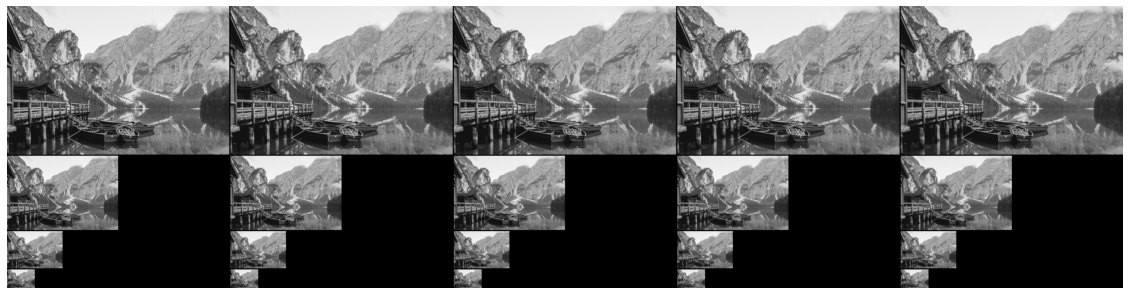

In [170]:
num_octave = 4
s = 2
sigma = 0.5

fig1 = plt.imread("./figure1.jpg")
fig1 = rgb2gray(fig1)

p = generate_gaussian_pyramid(fig1,num_octave,s,sigma)

output_pyr = plot_pyramid(p,fig1.shape)

fig = plt.figure(figsize=(20, 20))

plt.imshow(output_pyr,cmap="gray")
plt.axis('off')
plt.show()

# Esercizio 2


Data la seguente sequenza di tensori e la funzione *f*, calcolare il gradiente per i tensori a,b,c,d,e,y. 

Descrivere come viene costruito il grafo di computazione mostrando quali operazioni vengono effettuate, cioè calcolando le derivate parziali in maniera esplicita. 

$
y = f(a,b,c,d,e) = \sum \frac {a^5 + \exp(b^2) * \cos (c) * d} {3e + 1}
$

*non sono necessarie librerie esterne*

la derivata parziale rispetto ad a



In [171]:
a = torch.tensor([5, 6, 7, 8, 1, 2], dtype=torch.float, requires_grad=True).view(3, 2)
b = torch.tensor([3, 3, 0, 1, 6, 2], dtype=torch.float, requires_grad=True).view(3, 2)
c = torch.tensor([1, 5, 0, 7, 4, 3], dtype=torch.float, requires_grad=True).view(3, 2)
d = torch.tensor([2, 6, 3, 8, 3, 1], dtype=torch.float, requires_grad=True).view(3, 2)
e = torch.tensor([5, 2, 1, 1, 1, 1], dtype=torch.float, requires_grad=True).view(3, 2)

a.retain_grad()
b.retain_grad()
c.retain_grad()
d.retain_grad()
e.retain_grad()

# calcolo a^5

z1 = a**5
z1.retain_grad()

# calcolo cos(c) 
z2 = torch.cos(c)
z2.retain_grad()

# calcolo exp(b^2) * cos(c) * d
z3 = torch.exp(b**2) * z2 * d
z3.retain_grad()

# calcolo z1 + z3
z4 = z1 + z3 
z4.retain_grad()

# calcolo 3e +1

cost = torch.tensor([1],dtype=torch.float,requires_grad=True)

z5 = torch.exp(cost)*3 +1
z5.retain_grad()

# calcolo z4 / z5

z6 = z4/z5
z6.retain_grad()

out = torch.sum(z6)
out.retain_grad()

print(out)
out.backward()

tensor(-9.2345e+14, grad_fn=<SumBackward0>)


In [172]:

print('GRAD:')
print(f'grad a: {a.grad}')
print(f'grad b: {b.grad}')
print(f'grad c: {c.grad}')
print(f'grad d: {d.grad}')
print(f'grad e: {e.grad}')
print(f'grad z1: {z1.grad}')
print(f'grad z2: {z2.grad}')
print(f'grad z3: {z3.grad}')
print(f'grad z4: {z4.grad}')
print(f'grad z5: {z5.grad}')
print(f'grad z6: {z6.grad}')
print(f'grad o: {out.grad}')

GRAD:
grad a: tensor([[3.4135e+02, 7.0782e+02],
        [1.3113e+03, 2.2371e+03],
        [5.4616e-01, 8.7385e+00]])
grad b: tensor([[ 5.7388e+03,  9.0386e+03],
        [ 0.0000e+00,  3.5816e+00],
        [-1.1081e+16, -2.3617e+01]])
grad c: tensor([[-1.4896e+03,  5.0925e+03],
        [-0.0000e+00, -1.5606e+00],
        [ 1.0692e+15, -8.4162e-01]])
grad d: tensor([[ 4.7823e+02,  2.5107e+02],
        [ 1.0923e-01,  2.2385e-01],
        [-3.0782e+14, -5.9042e+00]])
grad e: None
grad z1: tensor([[0.1092, 0.1092],
        [0.1092, 0.1092],
        [0.1092, 0.1092]])
grad z2: tensor([[1.7702e+03, 5.3107e+03],
        [3.2770e-01, 2.3754e+00],
        [1.4128e+15, 5.9639e+00]])
grad z3: tensor([[0.1092, 0.1092],
        [0.1092, 0.1092],
        [0.1092, 0.1092]])
grad z4: tensor([[0.1092, 0.1092],
        [0.1092, 0.1092],
        [0.1092, 0.1092]])
grad z5: tensor([1.0087e+14])
grad z6: tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])
grad o: 1.0


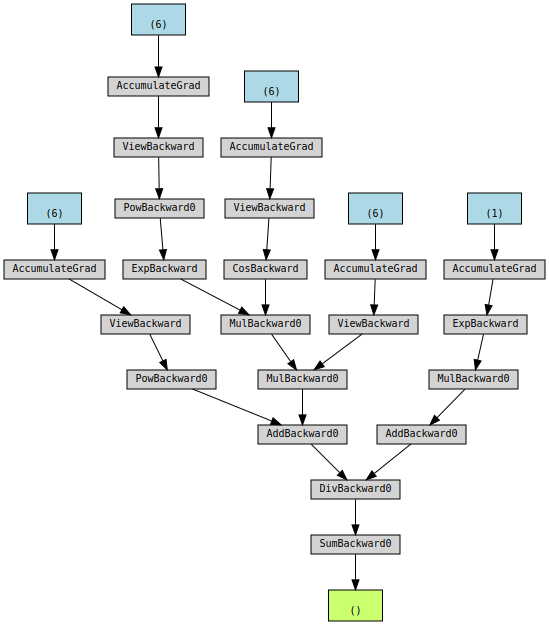

In [173]:
import torchviz

torchviz.make_dot(out,{"a":a,"b":b,"c":c,"d":d,"e":e})

# Esercizio 3

Dati due batch A e B, mostrare gli effetti della BN.

Suggerimento: calcolare gli istogrammi di A e B

Before BN -> 1 batch mean:9.99895191192627 ---- 2 batch mean:99.99943542480469
After BN -> 1 batch mean:-0.9999385476112366 ---- 2 batch mean:0.9999386668205261


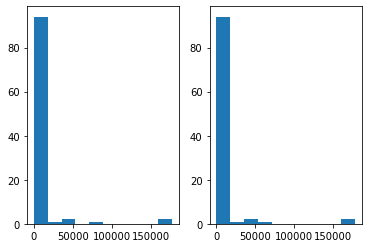

In [174]:
#covariance shift

# la bn stabilizza la distribuzione tra i vari batch 

#prima media 10 
# seconda media 100

# creo un dataset con batch che hanno medie diverse e poi lo passo a bn

A = torch.empty((100,3,30,30)).normal_(mean=10,std=0.5)
B = torch.empty((100,3,30,30)).normal_(mean=100,std=0.5)

dataset = torch.cat([A,B])

bn = nn.BatchNorm2d(3)

bn_dataset=bn(dataset)

print(f"Before BN -> 1 batch mean:{torch.mean(dataset[0:100])} ---- 2 batch mean:{torch.mean(dataset[100:200])}")
print(f"After BN -> 1 batch mean:{torch.mean(bn_dataset[0:100])} ---- 2 batch mean:{torch.mean(bn_dataset[100:200])}")



hist1 = torch.histc(dataset,)
hist2 = torch.histc(bn_dataset,bins=100)

plt.figure()
plt.subplot(121)
plt.hist(hist1.detach().numpy())
plt.subplot(122)
plt.hist(hist2.detach().numpy())
plt.show()

# Esercizio 4

Dato il seguente frammento di codice

Per calcolare i vari passaggi utilizzo questa formula : output = ((input_size - kernel_size + 2* padding)/stride) +1 

il risultato è un tensore di dimensione [1,30,66,50].

L'immagine passa prima dal layer conv1, il quale applica 10 filtri,
perciò il risultato avrà 10 canali. Inoltre siccome utilizza come valore di padding 1, 
[ p= (kernel_size-1)/2 -> stessa dimensione tra livelli senza considerare altri parametri],
e uno stride uguale a 2, l'altezza e la larghezza saranno dimezzate e quindi uguale a 200.   

1x3x400x400 ---conv1---> 1x10x200x200 

Questo nuovo tensore ora passa da conv2, che applica 30 filtri perciò avremo 30 canali nel risultato. 
Inoltre siccome utilizza parametri differenti per altezza e larghezza, vanno considerate singolarmente.
Utilizzo la formula riportata sopra:

    1. Larghezza: output = ((200 - 3 + 2*0)//3)+1 = 66 
    2. Altezza: output = ((200 - 5 + 2*1)//4)+1 = 50 
    
Perciò come risultato:
1x10x200x200  ---conv2---> 1x30x66x50

In [175]:
conv1 = torch.nn.Conv2d(3, 10, kernel_size=3, padding=1, stride=2)
conv2 = torch.nn.Conv2d(10, 30, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))

model = lambda x: conv2(conv1(x))


img = torch.rand((1,3,400,400))

temp1 = conv1(img)
print(temp1.shape)
print(conv2(temp1).shape)


model(img).shape

torch.Size([1, 10, 200, 200])
torch.Size([1, 30, 66, 50])


torch.Size([1, 30, 66, 50])

Indicare giustificando la risposta qual'è il risultato per un'immagine 1x3x400x400 illustrandolo con un esempio. 

# Esercizio 5

Adattare/semplificare la rete VGG affinché gestisca un input di immagini 400x400

In [176]:
def test(net,img_size=32,input_channel=3):
    x = torch.randn(1,input_channel,img_size,img_size)
    y = net(x)
    print("Input: {}; Output: {}; N. of params: {:,}".format(list(x.size()), list(y.size()), count_parameters(net)))

class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        
        # passando un immagine 400x400, il risultato passante da features avrà come shape: [1, 512, 12, 12]
        # perciò devo cambiare in_features del primo layer lineare 
        
        #old_in_features = 512 * 7 * 7
        in_features = 512 * 12 * 12
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [177]:
vgg16 = VGG(make_layers(cfg['D']))

x = torch.randn(1,3,400,400)

print(vgg16(x).shape)



torch.Size([1, 1000])


# Esercizio 6

Data la seguente immagine, calcolare la IoU tra i due box mostrati in figura. 
Descrivere tutte le operazioni effettuate

In [178]:
#IoU = b1_area intersect b2_area / b1_area union b2_area 
def IoU(b1,b2):
    ya1, xa1, ya2, xa2 = b1
    
    # calcolo l'area del primo box
    b1_area = (ya2 - ya1) * (xa2 - xa1)
    
    
    yb1, xb1, yb2, xb2 = b2
    
    # calcolo l'area del secondo box
    b2_area = (yb2 - yb1) * (xb2 - xb1)
    
    inter_x1 = max(xb1, xa1)
    inter_y1 = max(yb1, ya1)
    inter_x2 = min(xb2, xa2)
    inter_y2 = min(yb2, ya2)
    
    # controllo se esiste una intersezione altrimenti è uguale a 0
    if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            
            #calcolo l'area di intersezione tra i due box
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            
            # calcolo l'unione : somma tra le 2 aree meno l'intersezione
            union = (b1_area + b2_area - iter_area)
            
            # calcolo IoU
            iou = iter_area / union
    else:
        iou = 0.
    
    return iou

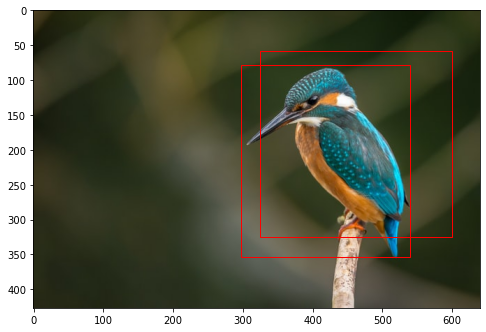

IoU: 0.6073376586094046


In [129]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import matplotlib.patches as patches

def plot_bbox(image_np, bbox_list):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(8, 8)

    ax.imshow(image_np)

    for bbox_idx in range(bbox_list.shape[0]):
        x1, y1, x2, y2 = bbox_list[bbox_idx, :].tolist()

        w = x2 - x1
        h = y2 - y1

        rect = patches.Rectangle((x1, y1), w, h,
                                 linewidth=1, 
                                 edgecolor='r', 
                                 facecolor='none')

        ax.add_patch(rect)

    plt.show();

imageBB1 = mp_image.imread('figure2.jpg')

bb1 = [297, 79, 540, 354]
bb2 = [325, 59, 600, 325]

plot_bbox(imageBB1, np.array([bb1, bb2]))

print(f"IoU: {IoU(bb1,bb2)}")
